# Tarea 03
Start up de bienes raices

- Objetivo: prototipa un modelo en Python que permita estimar el precio de una casa dadas algunas características que el usuario deberá proporcionar a través de un front al momento de la inferencia.

![Flujo de trabajo](imgs/flujo.png)

## Librerias

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import f_oneway
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

## Conjunto de Datos

Utilizaremos el conjuntos de datos de precios de compra-venta de casas de la ciudad Ames, Iowa en Estados Unidos disponible en [Kaggle](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques).

In [33]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [34]:
print("El conunto de datos de entrenamiento tiene {} filas y {} columnas".format(train.shape[0], train.shape[1]))
train.head()

El conunto de datos de entrenamiento tiene 1460 filas y 81 columnas


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


El objetivo consiste en predecir el precio de la casa `SalePrice` a partir del conjunto de características disponibles en el conjunto de datos. Por lo que comenzaremos con un análisis exploratorio de los datos para identificar las características más relevantes y posteriormente entrenar un modelo que nos permita predecir el precio de una casa.

## Análsis Exploratorio de Datos

Realizaremos un análisis exploratorio de los datos para entender mejor las características y su relación con el precio de venta de las casas.

### Valores Faltantes

Identificamos las columnas que tienen valores faltantes y el porcentaje de valores faltantes en cada una.

In [35]:
missing_values = train.isnull().sum()
missing_percentage = (train.isnull().sum() / len(train)) * 100
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})
missing_data = missing_data.sort_values(by='Missing Values', ascending=False)
missing_data.reset_index(inplace=True)
missing_data.rename(columns={'index': 'Column'}, inplace=True)

missing_data[missing_data['Missing Values'] > 0]

,Column,Missing Values,Percentage
0,PoolQC,1453,99.520548
1,MiscFeature,1406,96.301370
2,Alley,1369,93.767123
3,Fence,1179,80.753425
4,MasVnrType,872,59.726027
5,FireplaceQu,690,47.260274
6,LotFrontage,259,17.739726
7,GarageYrBlt,81,5.547945
8,GarageCond,81,5.547945
9,GarageType,81,5.547945


Analizando con un poco más de detalle los valores faltantes y revisando la descripción de los datos, podemos inferir que en algunos casos los valores faltantes corresponden a la ausencia de una característica en la casa, por lo que podemos reemplazar estos valores faltantes por un valor que represente la ausencia de la característica. Para las variables numéricas podemos reemplazar los valores faltantes por 0 y para las variables categóricas podemos reemplazar los valores faltantes por 'None'.

Además, eliminaremos la variable de `Id` ya que no aporta información relevante para el análisis.

In [36]:
train_clean = train.copy().drop(columns=['Id'])

numerical_cols = train_clean.select_dtypes(include=['number']).columns.tolist()
categorical_cols = train_clean.select_dtypes(include=['object']).columns.tolist()

train_clean[numerical_cols] = train_clean[numerical_cols].fillna(0)
train_clean[categorical_cols] = train_clean[categorical_cols].fillna("None")

Verificamos ya no existan valores nulos

In [37]:
print(train_clean.isna().sum().sum())

0


### Variables Numéricas

Las estadísticas descriptivas de las variables numéricas nos permiten identificar posibles valores atípicos y la distribución de las variables. Sin embargo, al tratarse de 34 variables numéricas, primero identificaremos las variables más correlacionadas con la variable objetivo `SalePrice`.

In [38]:
train_clean.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,57.623288,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.117123,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,34.664304,9981.264932,1.382997,1.112799,30.202904,20.645407,180.731373,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,0.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,42.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,63.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,79.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,164.250000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


Generamos un mapa de calor para visualizar la correlación entre las variables numéricas y nuestra variable a predecir `SalePrice`. Además, identificamos las variables con mayor correlación con la variable objetivo.

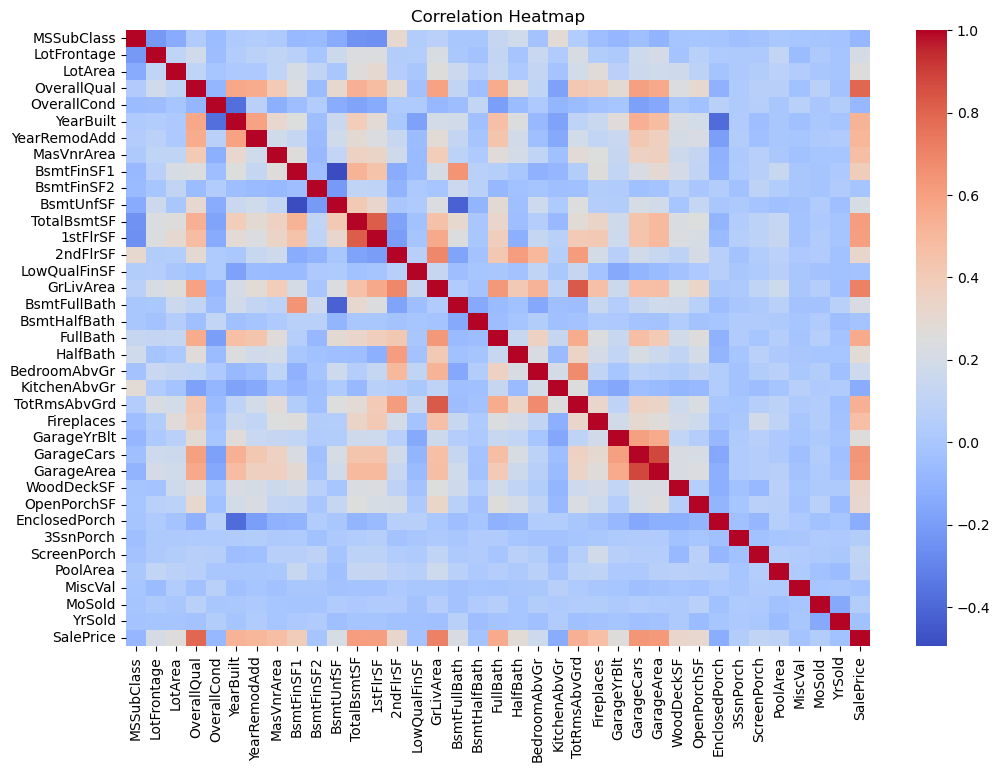

OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
MasVnrArea      0.472614
Fireplaces      0.466929
BsmtFinSF1      0.386420
WoodDeckSF      0.324413
2ndFlrSF        0.319334
OpenPorchSF     0.315856
Name: SalePrice, dtype: float64

In [39]:
# Correlation heatmap
corr = train_clean.select_dtypes(include=['int64', 'float64']).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap')
plt.show()

# features correlated with SalePrice
strong_corr = corr[corr['SalePrice'].abs() > 0.3]['SalePrice'].sort_values(ascending=False).drop('SalePrice')
strong_corr

El siguiente paso es visualizar la relación entre las variables más correlacionadas con la variable objetivo y `SalePrice` y verificar que no exista una alta correlación entre las variables independientes.

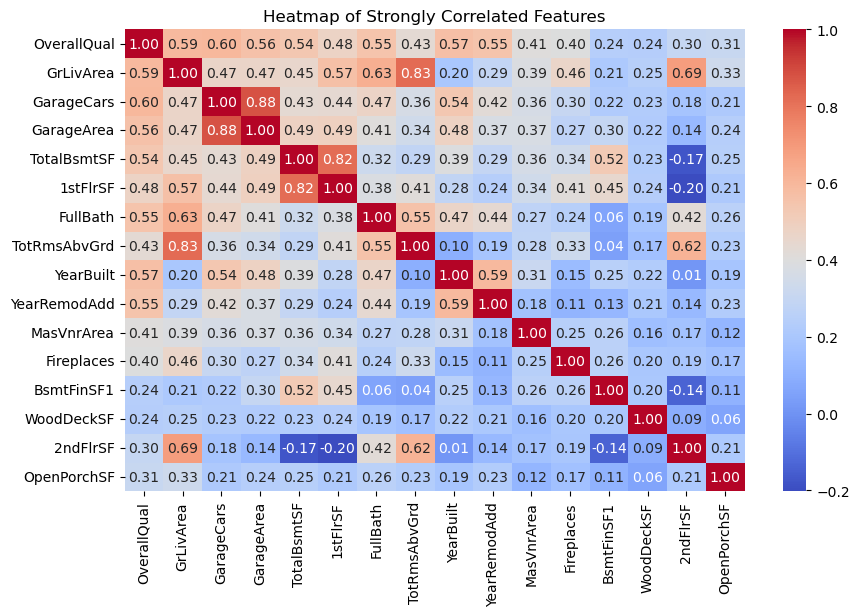

In [40]:
plt.figure(figsize=(10, 6))
sns.heatmap(train_clean[strong_corr.index].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap of Strongly Correlated Features')
plt.show()

In [41]:
corr_matrix = train_clean[strong_corr.index].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > .8)]
numerical_selected = [col for col in strong_corr.index if col not in to_drop]
numerical_selected

['OverallQual',
 'GrLivArea',
 'GarageCars',
 'TotalBsmtSF',
 'FullBath',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'Fireplaces',
 'BsmtFinSF1',
 'WoodDeckSF',
 '2ndFlrSF',
 'OpenPorchSF']

### Variables Categóricas

Para las variables categóricas, identificamos las categorías más frecuentes y su relación con la variable objetivo `SalePrice`. Además, al realizar una prueba ANOVA, identificamos las variables categóricas que tienen una relación significativa con la variable objetivo, por lo que seleccionamos aquellas con un p-value menor a 0.01.

In [42]:
categorical_features = train_clean.select_dtypes(include=['object', 'category']).columns

# Perform ANOVA for each categorical feature
anova_results = {}
for feature in categorical_features:
    categories = train_clean[feature].unique()
    groups = [train_clean[train_clean[feature] == category]['SalePrice'] for category in categories]
    f_statistic, p_value = f_oneway(*groups)
    anova_results[feature] = (f_statistic, p_value)

# Sort features by F-statistic (higher is better)
sorted_anova = sorted(anova_results.items(), key=lambda x: x[1][0], reverse=True)
sorted_features = [feature for feature, _ in sorted_anova]

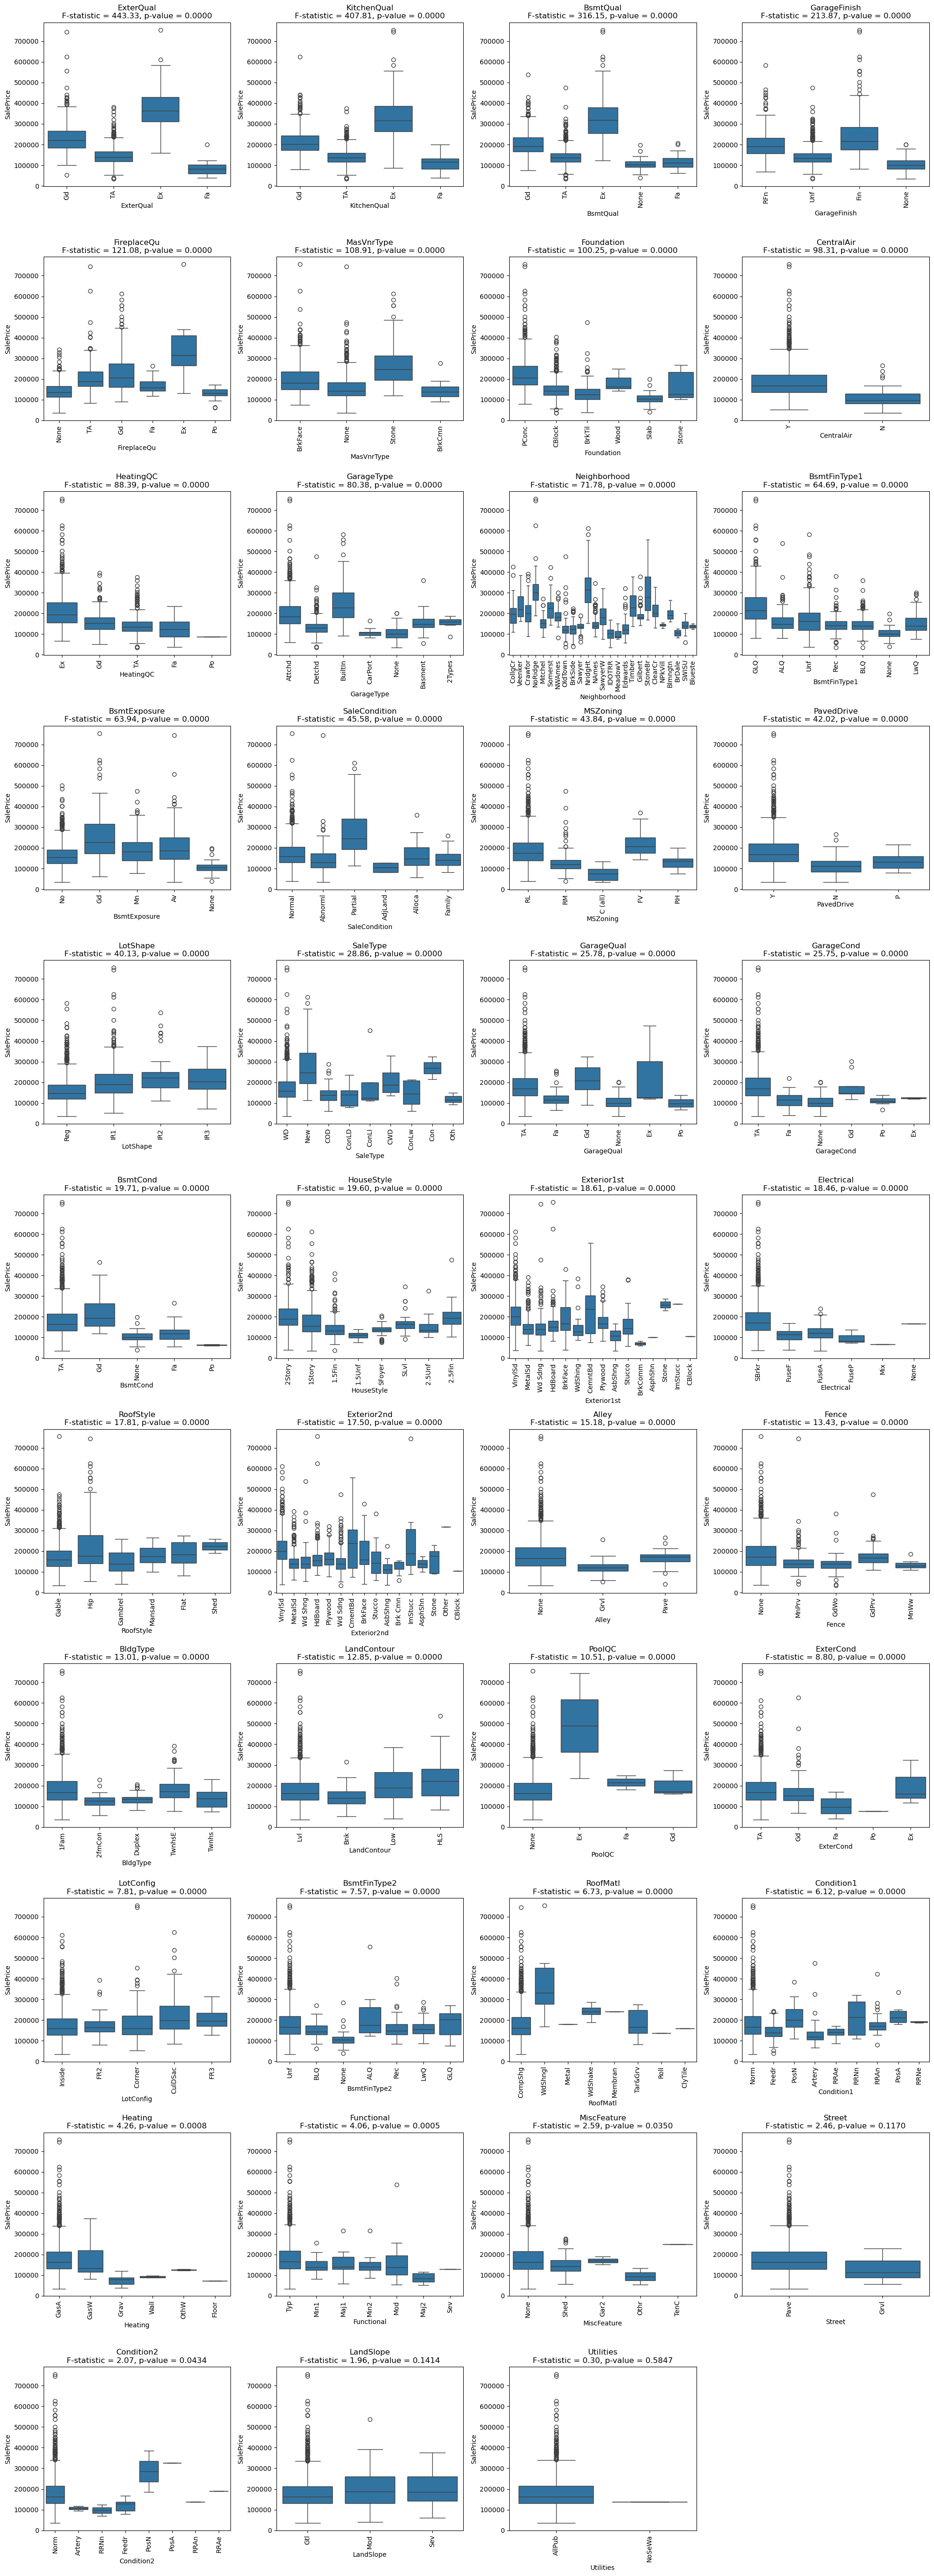

In [43]:
# Set up the grid
num_features = len(sorted_features)
num_cols = 4  # Number of columns in the grid
num_rows = (num_features // num_cols) + 1  # Number of rows needed

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

# Plot boxplots for each categorical feature in order of F-statistic
for i, feature in enumerate(sorted_features):
    sns.boxplot(x=feature, y='SalePrice', data=train_clean, ax=axes[i])
    axes[i].set_title(f'{feature}\nF-statistic = {anova_results[feature][0]:.2f}, p-value = {anova_results[feature][1]:.4f}')
    axes[i].tick_params(axis='x', rotation=90)

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [44]:
categorical_selected = {feature: (f_stat, p_val) for feature, (f_stat, p_val) in anova_results.items() if p_val < 0.01}
categorical_selected = list(categorical_selected.keys())
categorical_selected

['MSZoning',
 'Alley',
 'LotShape',
 'LandContour',
 'LotConfig',
 'Neighborhood',
 'Condition1',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'SaleType',
 'SaleCondition']

### Variables seleccionadas

Con base en lo anterior, seleccionamos las variables más correlacionadas con la variable objetivo y las variables categóricas que tienen una relación significativa con la variable objetivo para entrenar nuestro modelo.

In [45]:
selected_features = numerical_selected + categorical_selected + ['SalePrice']
selected_features

['OverallQual',
 'GrLivArea',
 'GarageCars',
 'TotalBsmtSF',
 'FullBath',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'Fireplaces',
 'BsmtFinSF1',
 'WoodDeckSF',
 '2ndFlrSF',
 'OpenPorchSF',
 'MSZoning',
 'Alley',
 'LotShape',
 'LandContour',
 'LotConfig',
 'Neighborhood',
 'Condition1',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'SaleType',
 'SaleCondition',
 'SalePrice']

In [46]:
train_final = train_clean[selected_features]

## Modelos de Regresión

Primero, debemos transformar las variables categóricas en variables dummy para poder entrenar nuestro modelo de regresión. Posteriormente, dividimos nuestro conjunto de datos en entrenamiento y prueba.

In [47]:
X = train_final.drop(columns=['SalePrice'])
y = train_final['SalePrice']

# Encode categorical variables
X = pd.get_dummies(X, drop_first=True)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

### Regresión Lineal

Para el modelo de regresión lineal, utilizamos todas las variables seleccionadas para entrenar el modelo y evaluamos su desempeño con el conjunto de prueba.

In [48]:
# Initialize the model
model_linear = LinearRegression()

# Train the model
model_linear.fit(X_train, y_train)

# Make predictions
y_pred = model_linear.predict(X_val)

# Evaluate the model
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2:.2f}")

RMSE: 46579.92
R2 Score: 0.72


Si bien el desempeño del modelo de regresión lineal es aceptable, podemos intentar mejorar la predicción utilizando otros modelos de regresión. Otra opción es realizar una selección de características para identificar las variables más relevantes en la predicción del precio de la casa.

### Random Forest

En el modelo de Random Forest, utilizamos todas las variables seleccionadas para entrenar el modelo y evaluamos su desempeño con el conjunto de prueba.

In [49]:
# Initialize the model
model_forest = RandomForestRegressor(random_state=42)

# Train the model
model_forest.fit(X_train, y_train)

# Make predictions
y_pred = model_forest.predict(X_val)

# Evaluate the model
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2:.2f}")

RMSE: 29526.80
R2 Score: 0.89


Podemos observar que el modelo de Random Forest tiene un mejor desempeño que el modelo de regresión lineal, por lo que podemos considerar este modelo como una mejor opción para predecir el precio de una casa. Sin embargo, es importante considerar que el modelo de Random Forest puede tener un sobreajuste, por lo que es recomendable realizar una validación cruzada para evaluar su desempeño y ajustar los hiperparámetros del modelo.

## Resultados

Con nuestro modelo final, podemos predecir el precio de una casa dadas algunas características del conjuto de pruebas.

In [50]:
selected_features.remove('SalePrice') 

test_final = test[selected_features]
test_final = pd.get_dummies(test_final, drop_first=True)
test_final = test_final.reindex(columns=X_train.columns, fill_value=0)

test_pred = model_forest.predict(test_final)

Por último, generamos un archivo con las predicciones para el conjunto de prueba y lo guardamos en un archivo CSV para el submission en Kaggle.

In [51]:
# Create a DataFrame for submission
submission = pd.DataFrame({
    'Id': test['Id'],  # Use the 'Id' column from the test data
    'SalePrice': test_pred  # Predicted SalePrice values
})

# Save the submission file
submission.to_csv('../data/submission.csv', index=False)

# Display the first few rows of the submission file
print(submission.head())

     Id  SalePrice
0  1461  122023.50
1  1462  154126.50
2  1463  178871.76
3  1464  189165.23
4  1465  200399.80
